In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
#from numpy.linalg import inv, det
import george
from george import kernels

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

################################################################# 

In [2]:
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

pgc = table['pgc']
inc = table['inc']
pc0 = table['pc0']
u0   = table['u']
g0   = table['g']
r0   = table['r']
i0   = table['i']
z0   = table['z']
w1  = table['w1']
w2  = table['w2']
logWimx = table["logWimx"]
m21 = table["m21"]
mu50 = table["mu50"]
Wba = table["Wba"]
R50_w2 = table["R50_w2"]

u = u0-redCorrect(inc, pc0, band1='u', band2='w2')
g = g0-redCorrect(inc, pc0, band1='g', band2='w2')
r = r0-redCorrect(inc, pc0, band1='r', band2='w2')
i = i0-redCorrect(inc, pc0, band1='i', band2='w2')
z = z0-redCorrect(inc, pc0, band1='z', band2='w2')
w1 = w1-redCorrect(inc, pc0, band1='w1', band2='w2')

c21w = m21-w2



inFile = '../calibrators/corrected_mags_linewidth_all.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=-99999, names=True, dtype=None, encoding=None)
idd = table['pgc']
w2_ss = table['w2_ss']

In [3]:
len(idd)

10737

4 4 16.44 16.55
4992 4992 12.914 12.91
2812 2812 13.826 13.92
43278 43278 14.161 14.53
830 830 15.408 15.54


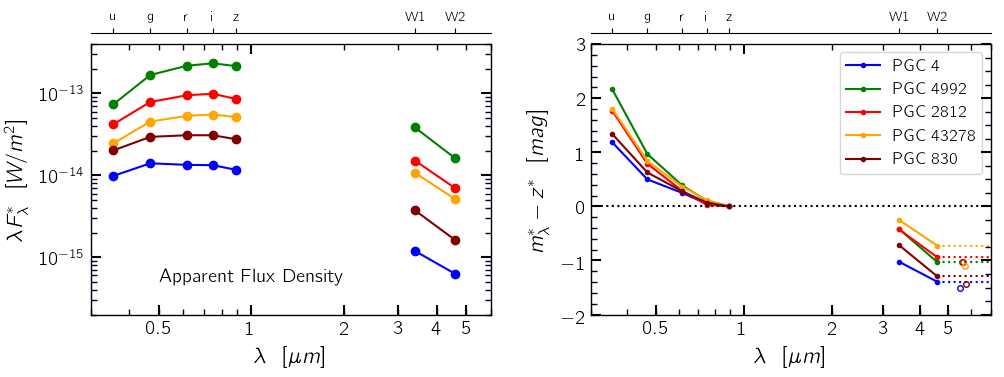

In [4]:
### All magnitudes are in AB system
### The AB system is defined such that every filter has a zero-point flux density of 3631 Jy 
### (1 Jy = 1 Jansky = 10-26 W Hz-1 m-2 = 10-23 erg s-1 Hz-1 cm-2).
def mag2Flux(m):
    
    F0 = 3631 # [Jy]
    F = F0*(10**(-0.4*m))
    return F
################################
C0 = 2.99792458     #  speed of light = C0*1.E8
lambda_u = 0.3551  # https://classic.sdss.org/dr7/instruments/imager/index.html
lambda_g = 0.4686  # micron
lambda_r = 0.6165
lambda_i = 0.7481
lambda_z = 0.8931
lambda_w1 = 3.4
lambda_w2 = 4.6
wavelengths = np.asarray([lambda_u, lambda_g, lambda_r, lambda_i, lambda_z, lambda_w1, lambda_w2])


fig = py.figure(figsize=(10, 7), dpi=100)    
fig.subplots_adjust(wspace=0.25, hspace=0.2, top=0.95, bottom=0.10, left=0.08, right=0.98) 
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 
p = 0

##################################### Left panel
dyes = ['b', 'g', 'r', 'orange', 'maroon', 'k']


ax = plt.subplot(gs[p]) ; p+=1

indx = np.argsort(r)
N = len(indx)
jjj=0
for j in [0, indx[N/5], indx[2*N/5], indx[3*N/5], indx[4*N/5]]:
    
    mags = np.asarray([u[j], g[j],r[j],i[j],z[j],w1[j],w2[j]])
    nuF_nu = ((C0*1.0E-12)/wavelengths)*mag2Flux(mags)
#     print wavelengths
#     print nuF_nu
    ax.plot(wavelengths[0:5], nuF_nu[0:5], 'o-', color=dyes[jjj])
    ax.plot(wavelengths[5:7], nuF_nu[5:7], 'o-', color=dyes[jjj])
    jjj+=1
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda ~~ [\mu m]$', fontsize=16)
ax.set_ylabel(r'$\lambda F^*_\lambda ~~ [W/m^2]$', fontsize=16)
ax.text(0.5, 5E-16, 'Apparent Flux Density', fontsize=14)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)      
ax.tick_params(which='major', length=7, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
ax.set_xlim(0.3,6)
ax.set_ylim(2.E-16,4.E-13)
plt.xticks([0.5,1,2,3,4,5], ('0.5','1','2','3','4','5'))


## additional Y-axis (on the right)
y_ax = ax.twinx()
y_ax.set_ylim(2.E-16,4.E-13)
y_ax.set_yscale('log')
y_ax.set_yticklabels([])
y_ax.minorticks_on()
y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

###additional X-axis (on the top)
x_ax = ax.twiny()
x_ax.set_xlim(0.3,6)
x_ax.set_xscale('log')
x_ax.set_xticklabels([])
x_ax.tick_params(which='major', length=7, width=1.5, direction='in')
x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.minorticks_off()
ax.minorticks_on()
# Decide the ticklabel position in the new x-axis,
# then convert them to the position in the old x-axis
newlabel = ['u','g','r','i','z','W1', 'W2']
newpos   = wavelengths
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel,  fontsize=16)

ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
ax2.xaxis.set_label_position('top') 
ax2.spines['top'].set_position(('outward', 8))
#ax2.set_xlabel('Band')
ax2.set_xlim(ax.get_xlim())


##################################### Right panel
        
ax = plt.subplot(gs[p]) ; p+=1
X0 = wavelengths # [:6]
jjj = 0 
for j in [0, indx[N/5], indx[2*N/5], indx[3*N/5], indx[4*N/5]]:
#     ax.plot(X0, [w2[j]-u[j], w2[j]-g[j],w2[j]-r[j],w2[j]-i[j],w2[j]-z[j],w2[j]-w1[j]], '.')

    Y0 = [u[j]-z[j], g[j]-z[j],r[j]-z[j],i[j]-z[j],z[j]-z[j],z[j]-w1[j], z[j]-w2[j]]
    ax.plot(X0[0:5], Y0[0:5], '.-', color=dyes[jjj])
    ax.plot(X0[5:7], Y0[5:7], '.-', color=dyes[jjj], label='PGC '+str(pgc[j]))
    ax.plot([X0[6],10], [Y0[6],Y0[6]], ':', color=dyes[jjj])
    
    if pgc[j] in idd:
        ix, = np.where(idd==pgc[j])
        print pgc[j], idd[ix][0], w2[j], w2_ss[ix][0]
        ax.plot([5.5+jjj*0.07], [z[j]-w2_ss[ix][0]], 'o', color=dyes[jjj], mfc='none', ms=4)
    
    
    
    jjj+=1
    
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda ~~ [\mu m]$', fontsize=16)
ax.set_ylabel(r'$m^*_\lambda-z^* ~~ [mag]$', fontsize=16)
# ax.text(0.5, -1.5,' Colors', fontsize=14)    
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
ax.tick_params(which='major', length=7, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

ax.set_xlim(0.3,7)
ax.set_ylim(-2,3)
plt.xticks([0.5,1,2,3,4,5], ('0.5','1','2','3','4','5'))


## additional Y-axis (on the right)
y_ax = ax.twinx()
y_ax.set_yticklabels([])
y_ax.minorticks_on()
y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

###additional X-axis (on the top)
x_ax = ax.twiny()
x_ax.set_xlim(0.3,7)
x_ax.set_xscale('log')
x_ax.set_xticklabels([])
x_ax.tick_params(which='major', length=7, width=1.5, direction='in')
x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')


ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.minorticks_off()
ax.minorticks_on()
# Decide the ticklabel position in the new x-axis,
# then convert them to the position in the old x-axis
newlabel = ['u','g','r','i','z','W1', 'W2']
newpos   = wavelengths
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel,  fontsize=16)

ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
ax2.xaxis.set_label_position('top') 
ax2.spines['top'].set_position(('outward', 8))
#ax2.set_xlabel('Band')
ax2.set_xlim(ax.get_xlim())

ax.plot([-2,10], [0,0], 'k:')

ax.legend(fontsize=12, loc=0)

-0.07445050302180611 0.4506151516085364 -1.0666274233139248 0.3279030520558646


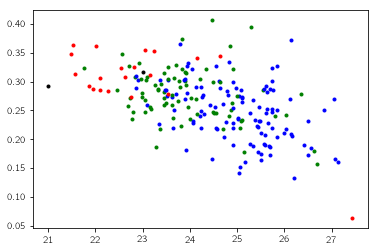

In [5]:
ri = r-i
gr = g-r
iw = i-w2

print np.min(ri), np.max(ri), np.median(iw), np.std(iw)

indx = np.where(ri < 0.15)
ri = ri[indx]
gr = gr[indx]
iw = iw[indx]
mu50_ = mu50[indx]

indx = np.where(ri > 0.10)
ri = ri[indx]
gr = gr[indx]
iw = iw[indx]
mu50_ = mu50_[indx]

for j in range(len(ri)):
    if iw[j] < -1.0 and iw[j] > -1.3: 
        plt.plot(mu50_[j], gr[j], 'g.',alpha=1)
    elif iw[j] < -1.3: 
        plt.plot(mu50_[j], gr[j], 'b.',alpha=1)
    
    elif iw[j] < -0.7: 
        plt.plot(mu50_[j], gr[j], 'r.',alpha=1)    
    else: 
        plt.plot(mu50_[j], gr[j], '.', color='black',alpha=1.)   
         

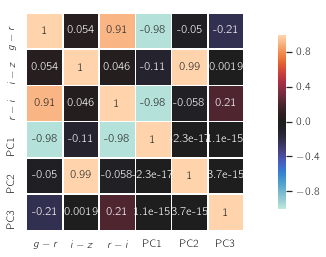

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

data = {'$g-r$':g-r, '$r-i$':r-i, '$i-z$':i-z}
order_of_keys = ['$g-r$', '$r-i$', '$i-z$']
list_of_tuples = [(key, data[key]) for key in order_of_keys]
data = OrderedDict(list_of_tuples)
d = pd.DataFrame.from_dict(data)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(d)
pca = PCA().fit(z_data)
pca_data = pca.transform(z_data)

Cp1 = pca_data[:,0]
Cp2= pca_data[:,1]
Cp3 = pca_data[:,2]


data = {'$g-r$':g-r, '$r-i$':r-i, '$i-z$':i-z, 'PC1':Cp1, 'PC2':Cp2, 'PC3':Cp3}
d = pd.DataFrame.from_dict(data)
### Compute the correlation matrix
corr = d.corr()
### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.0)
### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8, "pad":0.1}, annot_kws={"size": 12}, 
            annot=True) # , mask=mask)



# C1 = Cp1
# C2 = i-w2

# for j in range(len(C1)):
    
#     if pc0[j]<-1:
#         plt.plot(C1[j], C2[j], 'b.', alpha=0.2)
#     if pc0[j]>1:
#         plt.plot(C1[j], C2[j], 'r.', alpha=0.2)
#     if -1<pc0[j]<1:
#         plt.plot(C1[j], C2[j], 'g.', alpha=0.2)        

# plt.xlabel(r'$r-i ~~ [mag]$', fontsize=14)
# plt.ylabel(r'$i-W2 ~~ [mag]$', fontsize=14)
# plt.xlim([-1,1])
# plt.ylim([-3,3])


plt.show()

In [7]:
import random 

#################################################################
def my_shuffle(array):
        random.seed(5)
        random.shuffle(array)
        return array
#################################################################

M0 = logWimx
MU = mu50
C0 = c21w
C1 = g-w2
C2 = r-w2
C3 = i-w2
C4 = z-w2
C5 = w1-w2
GR = g-r
RI = r-i
G0 = g0
R0 = r0
I0 = i0
Z0 = z0
W2 = w2
M21 = m21
WBA = Wba
R50 = R50_w2


indices = np.arange(len(pgc))
indices = my_shuffle(indices)
MU = MU[indices]
M0 = M0[indices]
C0 = C0[indices]
C1 = C1[indices]
C2 = C2[indices]
C3 = C3[indices]
C4 = C4[indices]
C5 = C5[indices]
P0 = pc0[indices]
GR = GR[indices]
RI = RI[indices]
G0 = G0[indices]
R0 = R0[indices]
I0 = I0[indices]
Z0 = Z0[indices]
W2 = W2[indices]
M21 = M21[indices]
WBA = WBA[indices]
R50 = R50[indices]
INC = inc[indices]

N = 200   # number of cross validation data points

# cross validation set
MU_ = MU[:N]
M0_ = M0[:N]
C0_ = C0[:N]
C1_ = C1[:N]
C2_ = C2[:N]
C3_ = C3[:N]
C4_ = C4[:N]
C5_ = C5[:N]
P0_ = P0[:N]
GR_ = GR[:N]
RI_ = RI[:N]
G0_ = G0[:N]
R0_ = R0[:N]
I0_ = I0[:N]
Z0_ = Z0[:N]
W2_ = W2[:N]
M21_= M21[:N]
WBA_= WBA[:N]
R50_= R50[:N]
INC_=INC[:N]

# training set
MU = MU[N:]
M0 = M0[N:]
C0 = C0[N:]
C1 = C1[N:]
C2 = C2[N:]
C3 = C3[N:]
C4 = C4[N:]
C5 = C5[N:]
P0 = P0[N:]
GR = GR[N:]
RI = RI[N:]
G0 = G0[N:]
R0 = R0[N:]
I0 = I0[N:]
Z0 = Z0[N:]
W2 = W2[N:]
M21= M21[N:]
WBA= WBA[N:]
R50= R50[N:]
INC= INC[N:]

################################
n = 5  # number of features

N = len(P0)
X = np.ones(shape = (n,N))
X1 = np.ones(shape = (n,N))
X2 = np.ones(shape = (n,N))
X[0] = GR; X[1] = C2; X[2] = RI
X1[0] = GR; X1[1] = C2; X1[2] = RI
X2[0] = GR; X2[1] = C2; X2[2] = RI
X[3] = M0; X1[3] = MU; X2[3] = C0
X[4] = MU; X1[4] = C0; X2[4] = M0


N = len(P0_)
x = np.ones(shape = (n,N))
x1 = np.ones(shape = (n,N))
x2 = np.ones(shape = (n,N))
x[0] = GR_; x[1] = C2_; x[2] = RI_
x1[0] = GR_; x1[1] = C2_; x1[2] = RI_
x2[0] = GR_; x2[1] = C2_; x2[2] = RI_
x[3] = M0_; x1[3] = MU_; x2[3] = C0_
x[4] = MU_; x1[4] = C0_; x2[4] = M0_

Xy = X.T; Xy1 = X1.T; Xy2 = X2.T; 
xy = x.T; xy1 = x1.T; xy2 = x2.T;
################################
n = 4  # number of features

N = len(P0)
X = np.ones(shape = (n,N))
X1 = np.ones(shape = (n,N))
X2 = np.ones(shape = (n,N))
X[0] = GR; X[1] = C2; X[2] = RI
X1[0] = GR; X1[1] = C2; X1[2] = RI
X2[0] = GR; X2[1] = C2; X2[2] = RI
X[3] = M0; X1[3] = MU; X2[3] = C0


N = len(P0_)
x = np.ones(shape = (n,N))
x1 = np.ones(shape = (n,N))
x2 = np.ones(shape = (n,N))
x[0] = GR_; x[1] = C2_; x[2] = RI_
x1[0] = GR_; x1[1] = C2_; x1[2] = RI_
x2[0] = GR_; x2[1] = C2_; x2[2] = RI_
x[3] = M0_; x1[3] = MU_; x2[3] = C0_

Xz = X.T; Xz1 = X1.T; Xz2 = X2.T; 
xz = x.T; xz1 = x1.T; xz2 = x2.T;
################################

y = P0
y_ = P0_


# for j in range(100):
#     print j, INC_[j]

[0.16193058 0.13316628 0.70490314]
-0.0021087192933523236 0.08182010376302641
-0.016526945419000905 0.2161351094619809


(-1, 1)

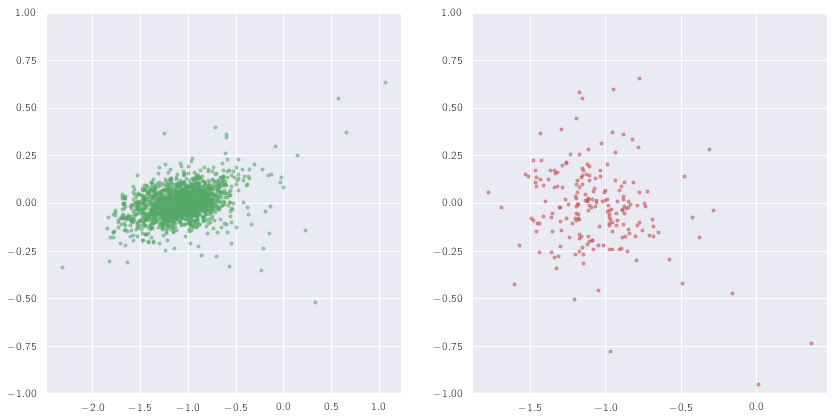

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

################################
n = 3  # number of features

N = len(P0)   # training
X1 = np.ones(shape = (n,N))
X1[0] = GR; X1[1] = RI#; X1[2] = C3-C4
X1[2] = MU;

N = len(P0_)  # cross validation
x1 = np.ones(shape = (n,N))
x1[0] = GR_; x1[1] = RI_#; x1[2] = C3_-C4_
x1[2] = MU_;

Xy1 = X1.T
xy1 = x1.T
################################

# outputs
y_esn = C3
y_esn_ = C3_


regrX = RandomForestRegressor(max_depth=2000, n_estimators=1000, max_features=3, \
                             min_samples_leaf=1, bootstrap=True)
regrX.fit(Xy1, y_esn)
yp_esn  = regrX.predict(Xy1)
yp_esn_ = regrX.predict(xy1)
print(regrX.feature_importances_)

plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1)

delta = y_esn-yp_esn
print np.median(delta), np.std(delta)
plt.plot(yp_esn, delta, 'g.', alpha=0.5)
plt.ylim([-1,1])
# a0, b0  = np.polyfit(delta, yp_esn, 1)
# xl = np.linspace(-3,3,100)
# yl = (xl - b0)/a0
# plt.plot(xl, yl, 'k--')

# yp_esn_ += (yp_esn_ - b0)/a0
delta = y_esn_-yp_esn_
ax = plt.gcf().add_subplot(1,2,2)
print np.median(delta), np.std(delta)
plt.plot(yp_esn_, delta, 'r.', alpha=0.5)
plt.ylim([-1,1])

81 -2.505 14.819


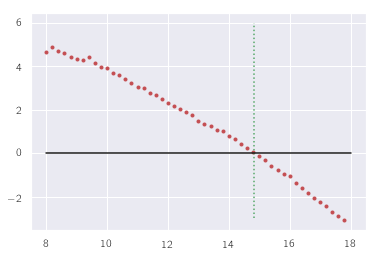

In [9]:
j = 90
# for j in range(100): print j, INC_[j]


for w2_t in np.arange(8,18,0.2):
    logWimx, c21w_t, mu50_t, P0_t = get_PC(w2_t, M21_[j], M0_[j], WBA_[j], R50_[j])

    g_t = G0_[j]-redCorrect(INC_[j], P0_t, band1='g', band2='w2')
    r_t = R0_[j]-redCorrect(INC_[j], P0_t, band1='r', band2='w2')
    i_t = I0_[j]-redCorrect(INC_[j], P0_t, band1='i', band2='w2')
    z_t = Z0_[j]-redCorrect(INC_[j], P0_t, band1='z', band2='w2')
    

    gr_t = g_t-r_t
    ri_t = r_t-i_t
    iz_t = i_t-z_t
    rw_t = r_t-w2_t
    iw_t = i_t-w2_t
    zw_t = z_t-w2_t

    x_t = np.asarray([[gr_t, ri_t, mu50_t]])
    rw_tp = regrX.predict(x_t)
    
    plt.plot([w2_t], [rw_t-rw_tp], 'r.')


plt.plot([W2_[j],W2_[j]], [-3,6], 'g:')
plt.plot([8,18], [0,0], 'k-')
print INC_[j], P0_[j], W2_[j]
plt.show()

[0.12900437 0.4929931  0.18983166 0.05566533 0.05617234 0.07633319]
0.009797693223262183 0.0907998394695551
0.01638299083929784 0.12174296413949422


(-1, 1)

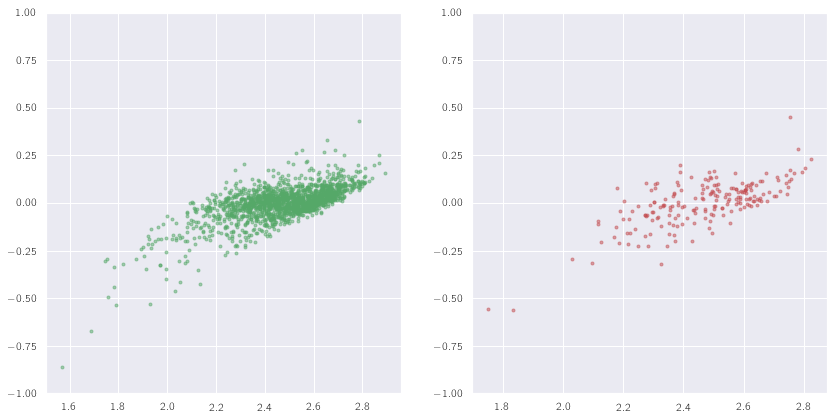

In [10]:
################################
n = 6  # number of features

N = len(P0)
X1 = np.ones(shape = (n,N))
X1[0] = GR; X1[1] = C2; X1[2] = RI; X1[3] = C4
X1[4] = MU
X1[5] = C0


N = len(P0_)
x1 = np.ones(shape = (n,N))
x1[0] = GR_; x1[1] = C2_; x1[2] = RI_; x1[3] = C4_
x1[4] = MU_
x1[5] = C0_

Xy1 = X1.T
xy1 = x1.T
################################


y_esn = M0
y_esn_ = M0_

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regrG = RandomForestRegressor(max_depth=2000, n_estimators=1000, max_features=5, \
                             min_samples_leaf=5, bootstrap=True)
regrG.fit(Xy1, y_esn)
yp_esn  = regrG.predict(Xy1)
yp_esn_ = regrG.predict(xy1)
print(regrG.feature_importances_)

plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1)

print np.median(y_esn-yp_esn), np.std(y_esn-yp_esn)
plt.plot(y_esn, y_esn-yp_esn, 'g.', alpha=0.5)
plt.ylim([-1,1])


ax = plt.gcf().add_subplot(1,2,2)
print np.median(y_esn_-yp_esn_), np.std(y_esn_-yp_esn_)
plt.plot(y_esn_, y_esn_-yp_esn_, 'r.', alpha=0.5)
plt.ylim([-1,1])


81 -2.505 2.126


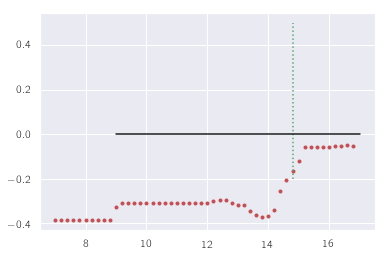

In [11]:
j = 90


for w2_t in np.arange(7,17,0.2):
    logWimx, c21w_t, mu50_t, P0_t = get_PC(w2_t, M21_[j], M0_[j], WBA_[j], R50_[j])

    g_t = G0_[j]-redCorrect(INC_[j], P0_t, band1='g', band2='w2')
    r_t = R0_[j]-redCorrect(INC_[j], P0_t, band1='r', band2='w2')
    i_t = I0_[j]-redCorrect(INC_[j], P0_t, band1='i', band2='w2')
    z_t = Z0_[j]-redCorrect(INC_[j], P0_t, band1='z', band2='w2')
    

    gr_t = g_t-r_t
    c2_t = r_t-w2_t
    ri_t = r_t-i_t
    m0_t = M0_[j]
    c0_t = c21w_t
    mu_t = mu50_t

#     x1_t = np.asarray([[gr_t, c2_t, ri_t, mu_t, c0_t]])
    x1_t = np.asarray([[gr_t, c2_t, ri_t, z_t, mu_t, c0_t]])
    logWimx_p = regrG.predict(x1_t)
    
    plt.plot([w2_t], [logWimx-logWimx_p], 'r.')


plt.plot([W2_[j],W2_[j]], [-0.2,0.5], 'g:')
plt.plot([9,17], [0,0], 'k-')
print INC_[j], P0_[j], logWimx
plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

##################
regr = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=5, bootstrap=True)
regr.fit(Xy, y)
yp  = regr.predict(Xy)
yp_ = regr.predict(xy)
print(regr.feature_importances_), np.std(y-yp), np.std(y_-yp_)
##################
regr1 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=5, bootstrap=True)
regr1.fit(Xy1, y)
yp1  = regr1.predict(Xy1)
yp1_ = regr1.predict(xy1)
print(regr1.feature_importances_), np.std(y-yp1), np.std(y_-yp1_)
##################
regr2 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=5, bootstrap=True)
regr2.fit(Xy2, y)
yp2  = regr2.predict(Xy2)
yp2_ = regr2.predict(xy2)
print(regr2.feature_importances_), np.std(y-yp2), np.std(y_-yp2_)
##################



[0.1460029  0.22806747 0.01859997 0.10456053 0.50276912] 0.26908574725174594 0.3191557620682028
[0.05657647 0.13250296 0.01499891 0.0088047  0.29943011 0.48768685] 0.27440395177476695 0.37220741935379376
[0.06937772 0.18874526 0.00791991 0.59962184 0.13433527] 0.2703795120820213 0.38412339967318143


In [13]:
##################
regrz = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=5, bootstrap=True)
regrz.fit(Xz, y)
ypz  = regrz.predict(Xz)
ypz_ = regrz.predict(xz)
print(regrz.feature_importances_), np.std(y-ypz), np.std(y_-ypz_)
##################
regrz1 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=5, bootstrap=True)
regrz1.fit(Xz1, y)
ypz1  = regrz1.predict(Xz1)
ypz1_ = regrz1.predict(xz1)
print(regrz1.feature_importances_), np.std(y-ypz1), np.std(y_-ypz1_)
##################
regrz2 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=5, bootstrap=True)
regrz2.fit(Xz2, y)
ypz2  = regrz2.predict(Xz2)
ypz2_ = regrz2.predict(xz2)
print(regrz2.feature_importances_), np.std(y-ypz2), np.std(y_-ypz2_)
##################


[0.3133753  0.57130029 0.02801976 0.08730465] 0.4155518539417858 0.5325540781987226
[0.17485654 0.27118752 0.04093847 0.51301747] 0.3577835022417986 0.4458031521478471
[0.0896531  0.27170558 0.01604603 0.62259529] 0.37078113624443515 0.5001527301201125


0.005648219251536357 0.19961691928944264
0.016432764178970688 0.25447201124439284


(-4, 4)

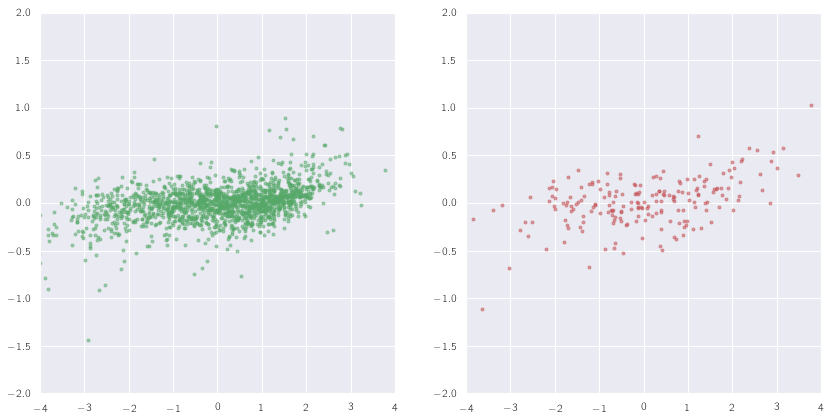

In [14]:
# yp0 = ((yp+yp1+yp2)+(ypz+ypz1+ypz2))/6.
# yp0_ = ((yp_+yp1_+yp2_)+(ypz_+ypz1_+ypz2_))/6.

# yp0 = np.c_[yp.ravel(),yp1.ravel(), yp2.ravel(), ypz.ravel(), ypz1.ravel(), ypz2.ravel()]
# yp0 = np.median(yp0,1)

# yp0_ = np.c_[yp_.ravel(),yp1_.ravel(), yp2_.ravel(), ypz_.ravel(), ypz1_.ravel(), ypz2_.ravel()]
# yp0_ = np.median(yp0_,1)


yp0 = np.c_[yp.ravel(), yp2.ravel()]
yp0 = np.median(yp0,1)

yp0_ = np.c_[yp_.ravel(), yp2_.ravel()]
yp0_ = np.median(yp0_,1)


# yp0 = np.c_[ypz.ravel(), ypz1.ravel(), ypz2.ravel()]
# yp0 = np.median(yp0,1)

# yp0_ = np.c_[ypz_.ravel(), ypz1_.ravel(), ypz2_.ravel()]
# yp0_ = np.median(yp0_,1)


plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1)

print np.median(y-yp0), np.std(y-yp0)
plt.plot(y, y-yp0, 'g.', alpha=0.5)
plt.ylim([-2,2])
plt.xlim([-4,4])

ax = plt.gcf().add_subplot(1,2,2)
print np.median(y_-yp0_), np.std(y_-yp0_)
plt.plot(y_, y_-yp0_, 'r.', alpha=0.5)
plt.ylim([-2,2])
plt.xlim([-4,4])

In [15]:
w2_t = 15.75

j = 90


for q in range(15):
    logWimx, c21w_t, mu50_t, P0_t = get_PC(w2_t, M21_[j], M0_[j], WBA_[j], R50_[j])

    g_t = G0_[j]-redCorrect(INC_[j], P0_t, band1='g', band2='w2')
    r_t = R0_[j]-redCorrect(INC_[j], P0_t, band1='r', band2='w2')
    i_t = I0_[j]-redCorrect(INC_[j], P0_t, band1='i', band2='w2')

    gr_t = g_t-r_t
    c2_t = r_t-w2_t
    ri_t = r_t-i_t
    m0_t = M0_[j]
    c0_t = c21w_t
    mu_t = mu50_t

    x_t  = np.asarray([[gr_t, c2_t, ri_t, m0_t, mu_t]])
    x2_t = np.asarray([[gr_t, c2_t, ri_t, c0_t, m0_t]])
    P0_1 = regr.predict(x_t)
    P0_2 = regr2.predict(x2_t)
#     P0_f = np.mean([P0_1, P0_2])
    
    xz_t  = np.asarray([[gr_t, c2_t, ri_t, m0_t]])
    xz1_t = np.asarray([[gr_t, c2_t, ri_t, mu_t]])
    xz2_t = np.asarray([[gr_t, c2_t, ri_t, c0_t]])
    P0_1z = regrz.predict(xz_t)
    P0_2z = regrz1.predict(xz1_t)
    P0_3z = regrz2.predict(xz2_t)
    
#     P0_f = P0_1z[0]
    P0_f = np.mean([P0_1z, P0_3z])
    
#     P0_f = np.median([P0_1, P0_2, P0_1z, P0_2z, P0_3z])

    w2_f = get_w(P0_f,  M21_[j], M0_[j], WBA_[j], R50_[j])
    print INC_[j], '%.2f'%w2_t, '%.2f'%w2_f, '%.2f'%W2_[j], '%.2f'%P0_t, '%.2f'%P0_f, '%.2f'%P0_[j]
    w2_t = w2_f

81 15.75 15.25 14.82 -3.40 -2.92 -2.50
81 15.25 14.89 14.82 -2.92 -2.58 -2.50
81 14.89 14.37 14.82 -2.58 -2.07 -2.50
81 14.37 13.49 14.82 -2.07 -1.23 -2.50
81 13.49 12.00 14.82 -1.23 0.19 -2.50
81 12.00 11.29 14.82 0.19 0.88 -2.50
81 11.29 11.21 14.82 0.88 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50
81 11.21 11.21 14.82 0.96 0.96 -2.50


# Using George Package

In [16]:
import george
from george import kernels

print X.shape
print y.shape
################################################################# 
def nll_fn2(X_train, Y_train):
      
    def step(theta):
        
        l1 = np.exp(theta[0])
        l2 = np.exp(theta[1])
        l3 = np.exp(theta[2])
        l4 = np.exp(theta[3])
        sigma = np.exp(theta[4])
        yerr = np.abs(0.2*Y_train)
        
        #kernel = sigma * kernels.Matern52Kernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])
        kernel = sigma * kernels.ExpSquaredKernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])

        gp = george.GP(kernel)
        gp.compute(X_train, yerr)

        return -gp.lnlikelihood(Y_train)
    return step
################################################################# 

### Maximum Likelihood
result = minimize(nll_fn2(X.T, y), [0, 0, 0, 0, 1], 
               bounds=((None, None), (None, None), (None, None), (None, None), (None, None)),
                       method='L-BFGS-B')
print result

(4, 1699)
(1699,)
      fun: 2965.250045901746
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.09494702e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 9
   status: 0
  success: True
        x: array([-16.50437413, -18.76639876,  -1.83662765, -17.42561243,
         0.53464541])


0.06237061434954217


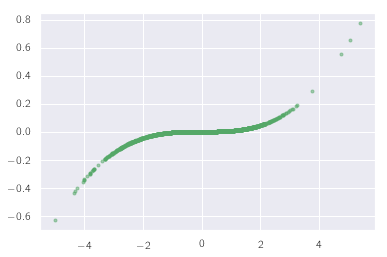

In [17]:
theta =  result.x
        
l1 = np.exp(theta[0])
l2 = np.exp(theta[1])
l3 = np.exp(theta[2])
l4 = np.exp(theta[3])
sigma = np.exp(theta[4])
yerr = np.abs(0.1*y)
kernel = sigma * kernels.ExpSquaredKernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])
gp = george.GP(kernel)
gp.compute(X.T, yerr)


y_pred, sigma = gp.predict(y, X.T, return_var=True)
print(np.sqrt(np.mean((P0-y_pred)**2)))
plt.plot(P0, P0-y_pred, 'g.', alpha=0.5)

1.480296319998128
1.480296073079639


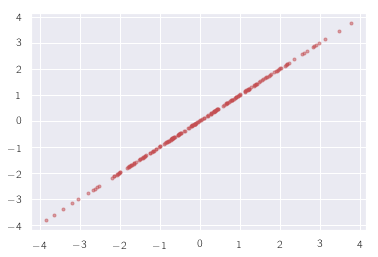

In [18]:
y_pred, sigma = gp.predict(y, x.T, return_var=True)
print(np.sqrt(np.mean((P0_-y_pred)**2)))
print np.std(P0_-y_pred)
plt.plot(P0_, P0_-y_pred, 'r.', alpha=0.5)